In [1]:
import tensorflow as tf
from tensorflow.python.keras import models as m
from tensorflow.python.keras import layers as l

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import confusion_matrix, fbeta_score
from scikitplot.metrics import plot_roc, plot_confusion_matrix

import seaborn as sn
import pandas as pd

from ROOT import TFile, TTree, TChain

print("All classes initialized successfully!!!")

Welcome to JupyROOT 6.18/04
All classes initialized successfully!!!


In [2]:
sigChan = TChain("varTree")
sigChan.Add("signal.root")
bkgChan = TChain("varTree")
bkgChan.Add("background.root")
print("Data read from the trees. Printing out the contents.")

Data read from the trees. Printing out the contents.


In [3]:
sigChan.Print()
bkgChan.Print()

******************************************************************************
*Chain   :varTree   : signal.root                                            *
******************************************************************************
******************************************************************************
*Tree    :varTree   : Input Variables List for Algorithms                    *
*Entries :    44440 : Total =         3213746 bytes  File  Size =    2732257 *
*        :          : Tree compression factor =   1.17                       *
******************************************************************************
*Br    0 :HtJet     : HtJet/D                                                *
*Entries :    44440 : Total  Size=     356973 bytes  File Size  =      24645 *
*Baskets :       12 : Basket Size=      32000 bytes  Compression=  14.46     *
*............................................................................*
*Br    1 :dRLL      : dRLL/D                        

In [4]:
# Read input data from root files
sigSampleSize = sigChan.GetEntries()
bkgSampleSize = bkgChan.GetEntries()

# Convert the input data to matrices
sigFull = sigChan.AsMatrix()
bkgFull = bkgChan.AsMatrix()

# Choose 20% of the data for testing and 80% of the data for training
sigTrain = sigFull[0:int(0.8*sigFull.shape[0])][:]
bkgTrain = bkgFull[0:int(0.8*bkgFull.shape[0])][:]
sigTest = sigFull[int(0.8*sigFull.shape[0]):][:]
bkgTest = bkgFull[int(0.8*bkgFull.shape[0]):][:]
print(sigTrain.shape)
print(bkgTrain.shape)
print(sigTest.shape)
print(bkgTest.shape)

(35552, 9)
(3286, 9)
(8888, 9)
(822, 9)


In [5]:
# Load the input data scaler
scaler = joblib.load("../scaler.save")

# Load the model
loaded_model = m.load_model("../simplePer.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                180       
_________________________________________________________________
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 38        
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________


2020-03-02 11:56:06.063046: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA


In [6]:
xTrain = np.concatenate((sigTrain,bkgTrain))
xTest = np.concatenate((sigTest,bkgTest))
yTrain = np.matrix([[1,0]]*sigTrain.shape[0]+[[0,1]]*bkgTrain.shape[0])
yTest = np.matrix([[1,0]]*sigTest.shape[0]+[[0,1]]*bkgTest.shape[0])

print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

(38838, 9)
(9710, 9)
(38838, 2)
(9710, 2)


In [7]:
# Randomize the training and testing samples
arr = np.arange(xTrain.shape[0])
np.random.shuffle(arr)
xTrain = xTrain[arr,:]
yTrain = yTrain[arr,:]

arr = np.arange(xTest.shape[0])
np.random.shuffle(arr)
xTest = xTest[arr,:]
yTest = yTest[arr,:]

In [8]:
# Predict on the samples
sigTrainScaled = scaler.transform(sigTrain)
bkgTrainScaled = scaler.transform(bkgTrain)
sigTestScaled = scaler.transform(sigTest)
bkgTestScaled = scaler.transform(bkgTest)
xTestScaled = scaler.transform(xTest)
sigTrainPredict = loaded_model.predict(sigTrainScaled)
bkgTrainPredict = loaded_model.predict(bkgTrainScaled)
sigTestPredict = loaded_model.predict(sigTestScaled)
bkgTestPredict = loaded_model.predict(bkgTestScaled)
xTestPredict = loaded_model.predict(xTestScaled)

In [9]:
print(sigTrainPredict[0:5])

[[0.81931347 0.18068655]
 [0.31268522 0.68731475]
 [0.9964335  0.00356646]
 [0.48883417 0.5111658 ]
 [0.9841636  0.01583642]]


In [10]:
print(np.array(sigTrainPredict)[0:5,0])

[0.81931347 0.31268522 0.9964335  0.48883417 0.9841636 ]


Discriminator plotted!!!


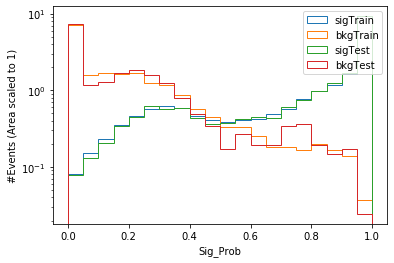

In [11]:
# Discriminator shape
plt.clf()
plt.yscale('log')
plt.hist(np.array(sigTrainPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='sigTrain')
plt.hist(np.array(bkgTrainPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='bkgTrain')
plt.hist(np.array(sigTestPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='sigTest')
plt.hist(np.array(bkgTestPredict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='bkgTest')
plt.xlabel("Sig_Prob")
plt.ylabel("#Events (Area scaled to 1)")
plt.legend()
plt.savefig("Discriminator.pdf")
print("Discriminator plotted!!!")

Confusion Matrix printed!!!


<Figure size 432x288 with 0 Axes>

<Figure size 720x504 with 0 Axes>

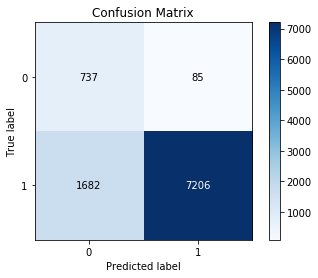

In [12]:
# Confusion Matrix
plt.clf()
plt.figure(figsize = (10,7))
plot_confusion_matrix(np.array(yTest)[:,0], np.array(xTestPredict)[:,0]>0.5)
plt.savefig("ConfusionMatrix.pdf")
print("Confusion Matrix printed!!!")

In [15]:
# For plots based on discriminator cut

sigProb = np.arange(0, 1, 0.01) 
xTestPredictSigProb = np.array(xTestPredict)[:,0] 
yTestClass = np.array(yTest)[:,0]

tpr = [] 
fpr = []

for x in sigProb: 
    xTestPredictClass = xTestPredictSigProb>x 
    tp = (xTestPredictClass&yTestClass).sum() 
    fp = (xTestPredictClass&(1-yTestClass)).sum() 
    fn = ((1-xTestPredictClass)&yTestClass).sum() 
    tn = ((1-xTestPredictClass)&(1-yTestClass)).sum()

    tpr.append(tp/(tp+fn))
    fpr.append(fp/(fp+tn))

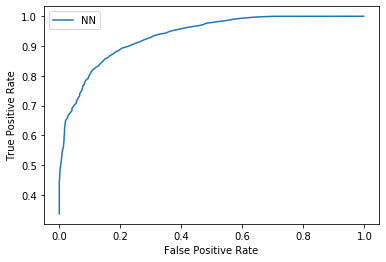

In [16]:
# ROC Curve

plt.clf()
plt.plot(fpr,tpr, label="NN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("roc.pdf")

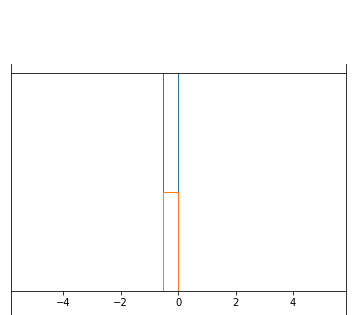

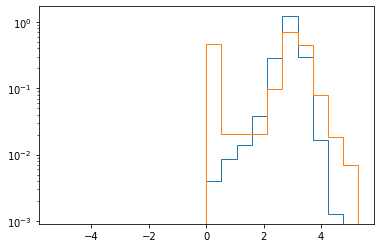

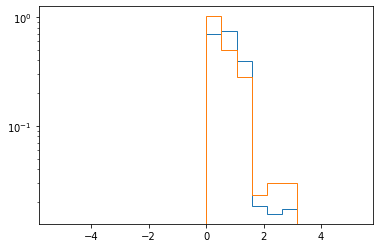

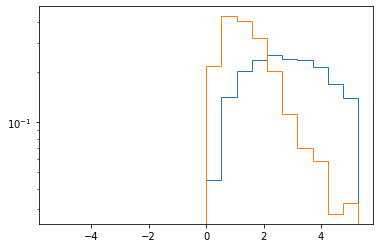

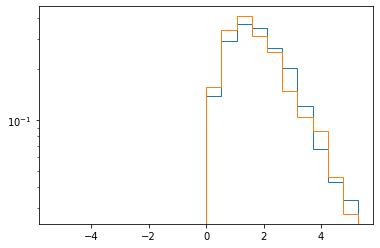

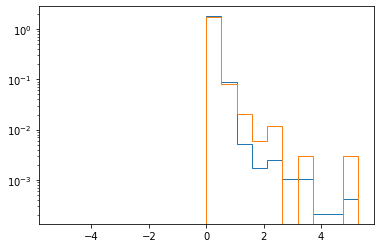

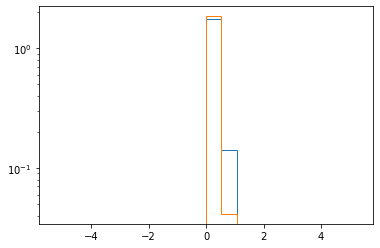

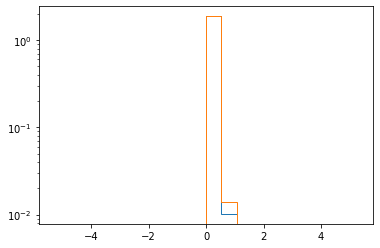

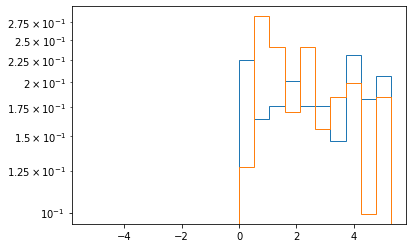

In [17]:
# Plots for scaled input variables above

for varCtr in np.arange(sigTest.shape[1]):
    plt.clf()
    plt.yscale('log')
    plt.hist(np.transpose(sigTest)[varCtr], bins=20, range=(-5.3,5.3), density=True, color=None, histtype='step', label='sigTest')
    plt.hist(np.transpose(bkgTest)[varCtr], bins=20, range=(-5.3,5.3), density=True, color=None, histtype='step', label='bkgTest')
    plt.show()
